<a href="https://colab.research.google.com/github/shajini3/Tree-Classification-Model/blob/main/treeClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
11/11 - 1s - loss: 1.0995 - accuracy: 0.3929 - val_loss: 1.0158 - val_accuracy: 0.3333 - 1s/epoch - 124ms/step
Epoch 2/10
11/11 - 0s - loss: 0.9744 - accuracy: 0.5119 - val_loss: 0.8717 - val_accuracy: 0.7143 - 66ms/epoch - 6ms/step
Epoch 3/10
11/11 - 0s - loss: 0.8706 - accuracy: 0.6190 - val_loss: 0.7429 - val_accuracy: 0.8571 - 49ms/epoch - 4ms/step
Epoch 4/10
11/11 - 0s - loss: 0.7410 - accuracy: 0.7857 - val_loss: 0.6261 - val_accuracy: 1.0000 - 66ms/epoch - 6ms/step
Epoch 5/10
11/11 - 0s - loss: 0.6941 - accuracy: 0.8095 - val_loss: 0.5310 - val_accuracy: 1.0000 - 66ms/epoch - 6ms/step
Epoch 6/10
11/11 - 0s - loss: 0.5550 - accuracy: 0.9405 - val_loss: 0.4437 - val_accuracy: 1.0000 - 65ms/epoch - 6ms/step
Epoch 7/10
11/11 - 0s - loss: 0.4977 - accuracy: 0.9643 - val_loss: 0.3683 - val_accuracy: 1.0000 - 54ms/epoch - 5ms/step
Epoch 8/10
11/11 - 0s - loss: 0.4108 - accuracy: 0.9881 - val_loss: 0.2999 - val_accuracy: 1.0000 - 65ms/epoch - 6ms/step
Epoch 9/10
11/11 - 0s - 

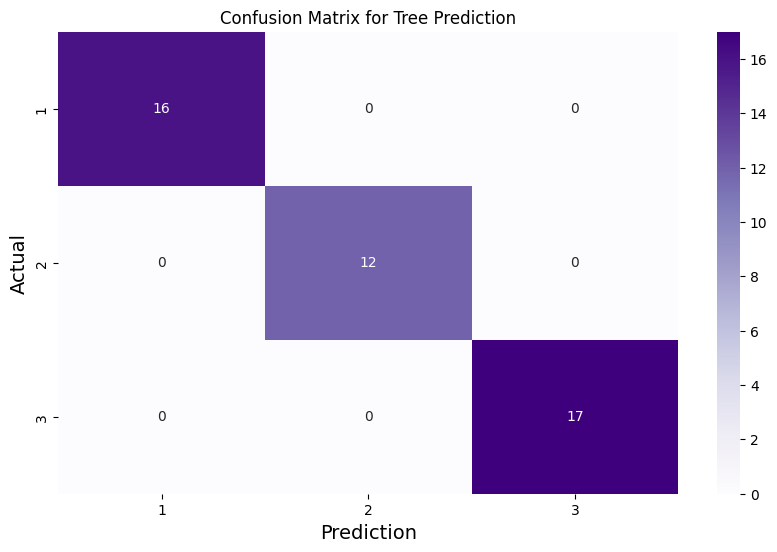

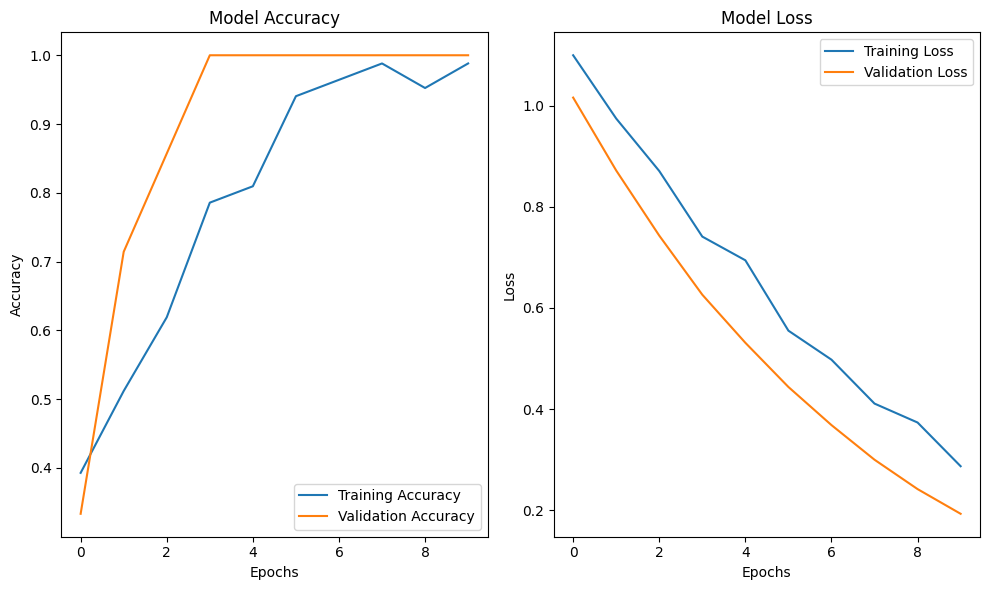

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf

# Load data
df = pd.read_csv('/content/tree_measurement.csv')

# Encode categorical data
le = LabelEncoder()
df['Outcome'] = le.fit_transform(df['Outcome'])
Outcome_name = le.classes_  # This will be used for plotting and output

# Prepare features and labels
x = df.drop(columns=['Sample No', 'Outcome'])
y = df['Outcome']

# Split data into training, testing, and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=69)  # Further split for validation

# Scale data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_val = keras.utils.to_categorical(y_val, num_classes=3)

# Define the model
model = Sequential([
    Dense(units=32, activation='relu', input_shape=(x_train.shape[-1],)),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation data and save the history
history = model.fit(x_train, y_train, epochs=10, batch_size=8, validation_data=(x_val, y_val), verbose=2)

# Define the prediction function with @tf.function to avoid retracing issues
@tf.function(reduce_retracing=True)
def predict_function(model, input_data):
    return model(input_data)

# Accept user input for prediction
print("Enter the feature values:")
user_input = [float(input(f"{col}: ")) for col in x.columns]

# Create a DataFrame with user input, ensuring the column names match
input_data = pd.DataFrame([user_input], columns=x.columns)

# Scale user input using the same scaler used for training data
input_data_scaled = sc.transform(input_data)
input_data_scaled = tf.convert_to_tensor(input_data_scaled, dtype=tf.float32)

# Make predictions
user_prediction = predict_function(model, input_data_scaled)
user_prediction = np.argmax(user_prediction, axis=-1)
predicted_class = Outcome_name[user_prediction[0]]
print(f"Predicted Class: {predicted_class}")
print("1-Kapok tree 2-Cassava tree 3-Silk cotton")

# Evaluate the model on the test data
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
prediction = predict_function(model, x_test_tensor)
prediction = np.argmax(prediction, axis=-1)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy: {accuracy}")

# Generate confusion matrix
cm = confusion_matrix(y_test, prediction)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=Outcome_name, yticklabels=Outcome_name)
ax.set_title('Confusion Matrix for Tree Prediction')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
